# Homework 2

In [186]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import csv

## Exercise 1

In [194]:
# first 10 entrys of female BMI and stature:
female_data = []
with open("female_train_data.csv", "r") as csv_file:
    female_reader = csv.reader(csv_file, delimiter=',')
    for row in female_reader:
        if row[0] != "index":
            row[1] = float(row[1])/10
            row[2] = float(row[2])/1000
            female_data.append([row[1],row[2]])
csv_file.close()
female_data = np.matrix(female_data)
print(female_data[0:10])

[[2.82  1.563]
 [2.22  1.716]
 [2.71  1.484]
 [2.81  1.651]
 [2.55  1.548]
 [2.3   1.665]
 [3.56  1.564]
 [3.11  1.676]
 [2.46  1.69 ]
 [4.3   1.704]]


In [195]:
# first 10 entries of male BMI and stature
male_data=[]
with open("male_train_data.csv", "r") as csv_file:
    male_reader = csv.reader(csv_file, delimiter=',')
    for row in male_reader:
        if row[0] != "index":
            row[1] = float(row[1])/10
            row[2] = float(row[2])/1000
            male_data.append([row[1],row[2]])
csv_file.close()
male_data = np.matrix(male_data)
print(male_data[0:10])

[[3.    1.679]
 [2.56  1.586]
 [2.42  1.773]
 [2.74  1.816]
 [2.59  1.809]
 [2.53  1.662]
 [2.27  1.829]
 [2.54  1.686]
 [3.41  1.761]
 [3.34  1.797]]


## Exercise 2

2-a

$||y-X\theta||^{2} = (y-X\theta)^{T}(y-X\theta) = y^{T}y - y^{T}X\theta-\theta^{T}X^{T}y - \theta^{T}X^{T}X\theta = y^{T}y-2y^{T}X\theta+\theta^{T}X^{T}X\theta$

$\frac{\partial(y^{T}y-2y^{T}X\theta+\theta^{T}X^{T}X\theta)}{\partial \theta} = -2X^{T}y+2X^{T}X\theta$

$-2X^{T}y+2X^{T}X\theta = 0$

$\theta = (X^{T}X)^{-1}X^{T}y$

The conditions that the solution is unique is X is full rank.

Two techniques that can be used when $X^{T}X$ is not invertible are:
- regularization
- pseudo-inversion


In [216]:
#2-b
y_male = np.matrix(np.ones(male_data.shape[0])).T
y_female = np.matrix(-1*np.ones(female_data.shape[0])).T
y = np.vstack((y_male,y_female))
X = np.vstack((male_data,female_data))
bias = np.matrix(np.ones(y.shape[0]))
X=np.vstack((X.T,bias)).T
theta_direct_solve = np.linalg.inv((X.T)@X)@(X.T)@y
print(theta_direct_solve)

[[ -0.12339677]
 [  6.67486843]
 [-10.7017505 ]]


In [217]:
#2-c
d = 3
theta = cp.Variable(d)
y=np.array(y).reshape((-1,))
objective = cp.Minimize(cp.sum_squares(y-X@theta))
prob = cp.Problem(objective)
prob.solve()
theta_vanilla = theta.value
print(theta_vanilla)

[ -0.12339677   6.67486843 -10.7017505 ]


2-d

As we derived in the 2-a, the gradient of the optimization function is $-2X^{T}y+2X^{T}X\theta$

We have $f(\theta) = (y-X\theta)^{T}(y-X\theta) = y^{T}y-2y^{T}X\theta+\theta^{T}X^{T}X\theta$

Throw the constant term, we end up with $f(\theta) = -2y^{T}X\theta+\theta^{T}X^{T}X\theta$

Now, let's map this to the lecture notes equation where $f(x) = \frac{1}{2}x^{T}Hx+c^{T}x$

we have $H = 2X^{T}X,\ c=(-2y^{T}X)^{T} = -2X^{T}y$

Therefore, $\alpha^{k}= \frac{\nabla (f(\theta)^{k})^{T}d^{k}}{(d^{k})^{T}Hd^{k}}$

$\nabla f(\theta) = 2X^{T}X\theta-2X^{T}y$

$d^{k} = \nabla f $

Substitue above into equation, we end up with:

$\alpha^{k} = \frac{(2X^{T}X\theta-2X^{T}y)^{T}\nabla f}{(\nabla f)^{T}2X^{T}X \nabla f} =\frac{\nabla f^{T}X^{T}X\theta -y^{T}X\nabla f}{(\nabla f)^{T}X^{T}X \nabla f}$

In [218]:
#2-e
d = 3
y=np.array(y).reshape((-1,1))
theta_grad = np.matrix(np.zeros(d)).T
XtX = X.T@X

for i in range(50000):
    grad =2*XtX@theta_grad - 2*X.T@y
    alpha = (grad.T@XtX@theta_grad-y.T@X@grad)/(grad.T@XtX@grad)
    theta_grad = theta_grad - np.multiply(alpha[0][0],grad)
print(theta_grad)

[[ -0.12339677]
 [  6.67486843]
 [-10.7017505 ]]


[[ -0.12339677]
 [  6.67486843]
 [-10.7017505 ]]


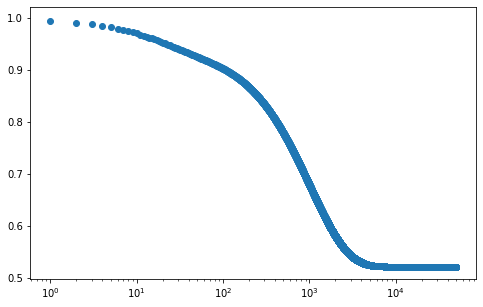

In [219]:
#2-f
d = 3
y=np.array(y).reshape((-1,1))
theta_grad = np.matrix(np.zeros(d)).T
XtX = X.T@X
loss = np.zeros(50000)
N=y.shape[0]

for i in range(50000):
    grad =2*XtX@theta_grad - 2*X.T@y
    alpha =((grad.T@XtX@theta_grad-y.T@X@grad)/(grad.T@XtX@grad))
    theta_grad = theta_grad - np.multiply(alpha[0][0],grad)
    loss[i] = np.linalg.norm(np.dot(X, theta_grad)-y)**2/N
print(theta_grad)
fig = plt.figure(figsize = (8,5))   
plt.semilogx(loss,'o',linewidth=8)

In [220]:
#2-g
d = 3
y=np.array(y).reshape((-1,1))
theta_grad = np.matrix(np.zeros(d)).T
XtX = X.T@X
loss = np.zeros(50000)
N=y.shape[0]
beta = 0.9
dJ_old = np.matrix(np.zeros(d)).T

for i in range(50000):
    dJ = X.T@X@theta_grad - X.T@y
    dd = beta*dJ_old + (1-beta)*dJ
    alpha  = ((dJ.T@dd) / (dd.T@XtX@dd))
    theta_grad  = theta_grad - np.multiply(alpha[0][0],dd)
    dJ_old = dJ
    loss[i] = np.linalg.norm(np.dot(X, theta_grad)-y)**2/N
print(theta_grad)


[[ -0.12339677]
 [  6.67486843]
 [-10.7017505 ]]


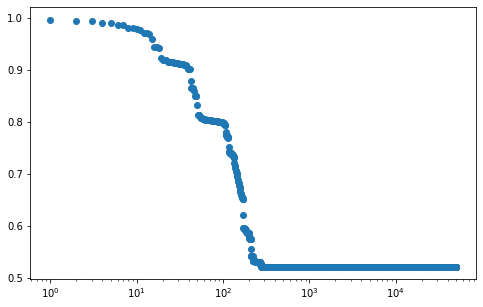

In [221]:
#2-h
fig = plt.figure(figsize = (8,5))   
plt.semilogx(loss,'o',linewidth=8)

## Exercise 3

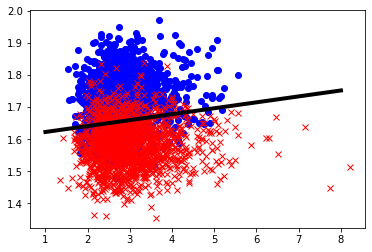

In [223]:
#3-a
plt.plot(np.array(male_data.T)[0],np.array(male_data.T)[1],'bo')
plt.plot(np.array(female_data.T)[0],np.array(female_data.T)[1],'rx')
x_1=np.linspace(1,8,100)
x_2 = np.array(-(theta_grad[0]/theta_grad[1])*x_1-(theta_grad[2]/theta_grad[1])).T
plt.plot(x_1,x_2,'k',linewidth=4)

In [263]:
#b-i
female_test = []
with open("female_test_data.csv", "r") as csv_file:
    female_reader = csv.reader(csv_file, delimiter=',')
    for row in female_reader:
        if row[0] != "index":
            row[1] = float(row[1])/10
            row[2] = float(row[2])/1000
            female_test.append([row[1],row[2]])
csv_file.close()
female_test = np.matrix(female_test)
bias = np.ones(female_test.shape[0])
female_test = np.vstack((female_test.T,bias)).T
y_female_test = female_test@theta_grad
male_count = np.sum(np.array(y_female_test.T)[0]>0,axis=0)
type_1_err = male_count/female_test.shape[0]
print("Type 1 error of classifying male is {}".format(type_1_err))


Type 1 error of classifying male is 0.14171656686626746


In [264]:
#b-ii
male_test = []
with open("male_test_data.csv", "r") as csv_file:
    male_reader = csv.reader(csv_file, delimiter=',')
    for row in male_reader:
        if row[0] != "index":
            row[1] = float(row[1])/10
            row[2] = float(row[2])/1000
            male_test.append([row[1],row[2]])
csv_file.close()
male_test = np.matrix(male_test)
bias = np.ones(male_test.shape[0])
male_test = np.vstack((male_test.T,bias)).T
y_male_test = male_test@theta_grad
female_count = np.sum(np.array(y_male_test.T)[0]<0,axis=0)
type_2_err = female_count/male_test.shape[0]
print("Type 2 error of classifying female is {}".format(type_2_err))

Type 2 error of classifying female is 0.17964071856287425


In [265]:
#b-iii
TP = np.sum(np.array(y_male_test.T)[0]>0,axis=0)
FP = np.sum(np.array(y_female_test.T)[0]>0,axis=0)
FN = np.sum(np.array(y_male_test.T)[0]<0,axis=0)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
print("The precision of this classifier is {}".format(precision))
print("The recall of this classifier is {}".format(recall))

The precision of this classifier is 0.8526970954356846
The recall of this classifier is 0.8203592814371258


## Exercise 4

(3224, 3)


Text(0, 0.5, '$||X\\theta_{\\lambda}-y||_{2}^{2}$')

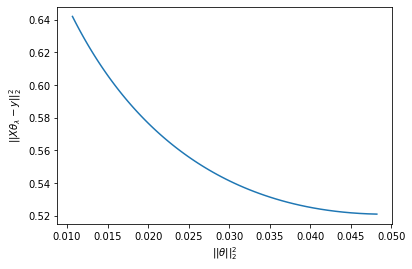

In [273]:
#4-a
lamda = np.arange(0.1,10,0.1)
y_male = np.matrix(np.ones(male_data.shape[0])).T
y_female = np.matrix(-1*np.ones(female_data.shape[0])).T
y = np.vstack((y_male,y_female))
X = np.vstack((male_data,female_data))
bias = np.matrix(np.ones(y.shape[0]))
X=np.vstack((X.T,bias)).T
N=y.shape[0]
print(X.shape)
theta_norm = []
loss_norm = []
for each in lamda:
    theta_tmp = np.linalg.inv(X.T@X+each*np.eye(X.shape[1]))@X.T@y
    norm_tmp = np.linalg.norm(np.dot(X, theta_tmp)-y)**2/N
    norm_theta = np.linalg.norm(theta_tmp)**2/N
    loss_norm.append(norm_tmp)
    theta_norm.append(norm_theta)
plt.plot(theta_norm,loss_norm)
plt.xlabel(r"$||\theta||_{2}^{2}$")
plt.ylabel(r"$||X\theta_{\lambda}-y||_{2}^{2}$")

Text(0, 0.5, '$||X\\theta_{\\lambda}-y||_{2}^{2}$')

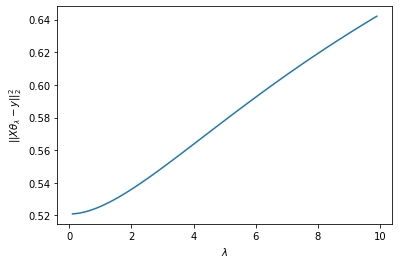

In [274]:
plt.plot(lamda,loss_norm)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$||X\theta_{\lambda}-y||_{2}^{2}$")

Text(0, 0.5, '$||\\theta||_{2}^{2}$')

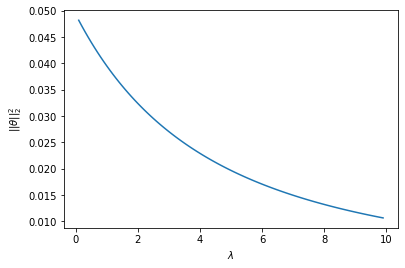

In [275]:
plt.plot(lamda,theta_norm)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$||\theta||_{2}^{2}$")

#4-b-i

For equation 4, rearrange the constraints, we have 

$\underset{\theta \in R^{d}}{\mathrm{argmin}} ||X\theta-y||_{2}^{2}$, subject to $\alpha-||\theta||_{2}^{2}\geq 0$

Lagrangian for 4 is: $\mathcal{L}(\theta,\gamma_{\alpha}) = ||X\theta-y||_{2}^{2}-\sum_{i=1}^{i=100}\gamma_{\alpha i}(\alpha-||\theta_{i}||_{2}^{2})$

For equation 5, rearrange the constraints, we have

$\underset{\theta \in R^{d}}{\mathrm{argmin}} ||\theta||_{2}^{2}$, subject to $\epsilon-||X\theta-y||_{2}^{2}\geq 0$

Lagrangian for 5 is: $\mathcal{L}(\theta,\gamma_{\epsilon}) = ||\theta||_{2}^{2}-\sum_{i=1}^{i=100}\gamma_{\epsilon i}(\epsilon-||X\theta_{i}-y||_{2}^{2})$

In [ ]:
#4-b-ii